# Text Classifier with CNN

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
df = pd.read_csv('../datasets/bbc/bbc_text_cls.csv')

In [3]:
# let's modify the data set to add a column with a different number for each label
df['targets'] = df['labels'].astype("category").cat.codes

In [4]:
# number of classes
K = df['targets'].max() + 1
K

5

In [5]:
df.head()

,text,labels,targets
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,0
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,0
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,0
3,High fuel prices hit BA's profits\n\nBritish A...,business,0
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,0


## Build Train and Test sets

In [6]:
df_train, df_test = train_test_split(df, test_size=0.3)

In [7]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 3500
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train['text'])
sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 27980 unique tokens.


In [9]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length, i.e length of the longest article.
T = data_train.shape[1]

Shape of data train tensor: (1557, 3797)


In [10]:
# Pad the test set with the lenght of the longest article in the training set.
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (668, 3797)


## Create the model

In [36]:
# Hyperparams
# Ebedding dimensionality
D = 75
nbr_epochs = 15

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

model = tf.keras.Sequential([
    Input(shape=(T,)),
    Embedding(V + 1, D),
    Conv1D(64, 3, activation='relu'),
    # MaxPooling1D(3),
    # Conv1D(16, 3, activation='relu'),
    # MaxPooling1D(3),
    # Conv1D(128, 3, activation='relu'),
    # MaxPooling1D(3),
    GlobalMaxPooling1D(),
    #Dense(32, activation='relu'),
    Dense(K)
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 3797, 75)          2098575   
                                                                 
 conv1d_11 (Conv1D)          (None, 3795, 64)          14464     
                                                                 
 global_max_pooling1d_7 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_8 (Dense)             (None, 5)                 325       
                                                                 
Total params: 2113364 (8.06 MB)
Trainable params: 2113364 (8.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  df_train['targets'],
  epochs=nbr_epochs,
  validation_data=(data_test, df_test['targets'])
)

Training model...
Epoch 1/15
49/49 [==============================] - 7s 133ms/step - loss: 1.5504 - accuracy: 0.5401 - val_loss: 1.4326 - val_accuracy: 0.7874
Epoch 2/15
49/49 [==============================] - 4s 87ms/step - loss: 1.1934 - accuracy: 0.8677 - val_loss: 0.9311 - val_accuracy: 0.8772
Epoch 3/15
49/49 [==============================] - 4s 90ms/step - loss: 0.6016 - accuracy: 0.9184 - val_loss: 0.4480 - val_accuracy: 0.9087
Epoch 4/15
49/49 [==============================] - 4s 83ms/step - loss: 0.2753 - accuracy: 0.9505 - val_loss: 0.2861 - val_accuracy: 0.9341
Epoch 5/15
49/49 [==============================] - 4s 80ms/step - loss: 0.1548 - accuracy: 0.9782 - val_loss: 0.2184 - val_accuracy: 0.9431
Epoch 6/15
49/49 [==============================] - 4s 70ms/step - loss: 0.0968 - accuracy: 0.9859 - val_loss: 0.1858 - val_accuracy: 0.9476
Epoch 7/15
49/49 [==============================] - 4s 72ms/step - loss: 0.0636 - accuracy: 0.9917 - val_loss: 0.1614 - val_accuracy: 0

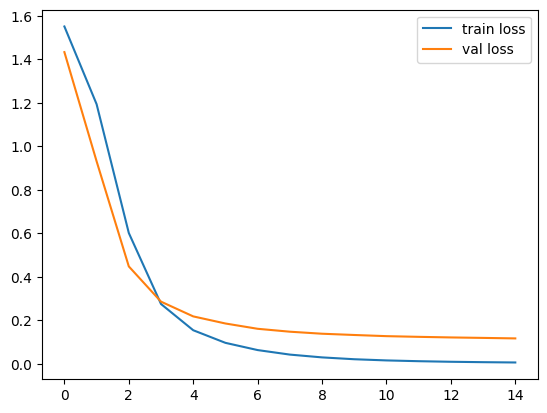

In [38]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

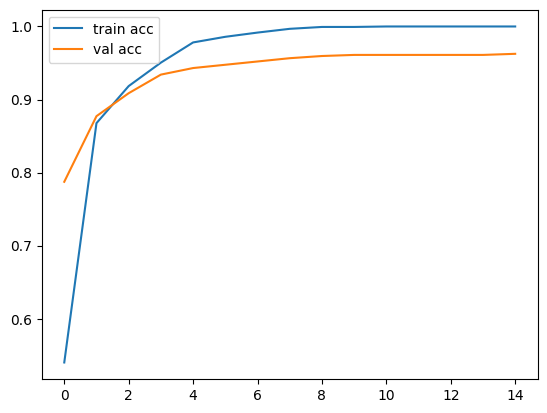

In [39]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();